<a href="https://colab.research.google.com/github/beidongjiedeguang/my-machine-learning/blob/master/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q kaggle

https://albahnsen.com/2018/07/22/how-to-download-kaggle-data-into-google-colab/

In [2]:

!mkdir -p ~/.kaggle

!echo '{"username":"kunyuanyao","key":"a2eca6702732598d05dfb812823e9670"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!mkdir -p data
!kaggle competitions download -c digit-recognizer

 81% 59.0M/73.2M [00:00<00:00, 152MB/s]
100% 73.2M/73.2M [00:00<00:00, 184MB/s]
 74% 36.0M/48.8M [00:00<00:00, 63.1MB/s]
100% 48.8M/48.8M [00:00<00:00, 139MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 43.9MB/s]


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [0]:
# Load the data
train = pd.read_csv(r"train.csv")
test = pd.read_csv(r"test.csv")

In [0]:
train.head()

In [0]:
Y_train = train['label']
X_train = train.drop('label',axis=1)

del train

In [69]:
X_train = X_train / 255.0
test = test / 255.0

print(X_train.shape,Y_train.size(0),test.shape)


class_num = 10
label = torch.LongTensor(Y_train)
print(label)

# 转换为one-hot 形式:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes,dtype=torch.long) 
    return y[labels] 

one_hot = one_hot_embedding(label, class_num)
print(one_hot.shape)
print(one_hot[:10,:])

torch.Size([42000, 1, 28, 28]) 42000 torch.Size([28000, 1, 28, 28])
tensor([1, 0, 1,  ..., 7, 6, 9])
torch.Size([42000, 10])
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


In [7]:
# 转换为pytorch 读入形状 
# Reshape image in 3 dimensions (Batch, 通道 ，height = 28px, width = 28px )
X_train = X_train.values.reshape(-1,1,28,28)
test = test.values.reshape(-1,1,28,28)

print(X_train.shape,test.shape)

(42000, 1, 28, 28) (28000, 1, 28, 28)


In [0]:
X_train,Y_train = torch.tensor(X_train, dtype = torch.float32),torch.tensor(Y_train)
test = torch.tensor(test,dtype = torch.float32)
# X_train= transforms.functional.to_pil_image(X_train)
# Y_train= transforms.functional.to_pil_image(Y_train)
# X_train,Y_train = transforms.ToTensor()(X_train), transforms.ToTensor()(Y_train)
# test = transforms.ToTensor()(test)

对已经读入的PIL.img进行变换：https://pytorch-cn.readthedocs.io/zh/latest/torchvision/torchvision-transform/ 
```python
from torchvision import transforms  
from PIL import Image  

img = Image.open('test.jpg')  

crop = transforms.Scale(12)
croped_img=crop(img) # 裁剪

img_tensor = transforms.ToTensor()(img) # 转换成tensor  
 
亦如参考代码： 下面能做到的，上面都可以变换得到。
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在把图像随机裁剪成32*32  
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转  
    transforms.RandomRotation((-45,45)), #随机旋转  
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.229, 0.224, 0.225)), #R,G,B每层的归一化用到的均值和方差，i.e. 第一个括号是均值，第二个是方差。
])

```
transforms.ToPILImage 可变换会Image格式，这样才能进行上面的操作

In [0]:
BATCH_SIZE=512

train_loader = Data.DataLoader(
    dataset = Data.TensorDataset(X_train,Y_train),
    batch_size= BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(
    dataset = test,
    batch_size= BATCH_SIZE, shuffle=True)

In [10]:
i=next(iter(train_loader))

print(i[0][2,0,:,:].dtype)
print(i[1].dtype)

torch.float32
torch.int64


torch.Size([512, 1, 28, 28])
torch.Size([3, 32, 242])
(32, 242, 3)


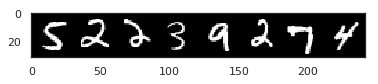

In [11]:
print(i[0].shape)
temp0 = torchvision.utils.make_grid(i[0][:8,:,:,:])
print(temp0.shape)
temp0=temp0.numpy().transpose((1,2,0))
print(temp0.shape)

plt.imshow(temp0)
plt.show()

In [0]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # 1,28x28
#         self.conv1 = nn.Conv2d(1,10,5)
# #         self.conv1 = nn.Conv2d(in_channels = 1,
# #                                out_channels = 10,
# #                                kernel_size = 5,
# #                                stride=1,
# #                                padding=0,
# #                                bias=True) 
#         self.conv2 = nn.Conv2d(10,20,3)
#         self.fc1 = nn.Linear(20*10*10,500) # input, output
#         self.fc2 = nn.Linear(500,10)
        
#     def forward(self,x):
#         batch_size = x.size(0)
#         out = self.conv1(x) #24
#         out = F.relu(out)
#         out = F.max_pool2d(out, 2, 2)  #12
#         out = self.conv2(out) #10
#         out = F.relu(out)
#         out = out.view(batch_size,-1)
#         out = self.fc1(out)
#         out = F.relu(out)
#         out = self.fc2(out)
#         out = F.log_softmax(out,dim=1)
#         return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [133]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU
print(DEVICE)


cuda


In [0]:
model = Net()

In [0]:
model = models.models.vgg19(pretrain=True)
for para in model.parameters():
    para.requires_grad = False
    
print(model)

model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.classifier[6] = nn.Linear(4096,10)
print(model)

In [0]:
model = models.SqueezeNet(version=1,num_classes=10)
print(model)
model.features[0] = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))

In [0]:
model = model.to(DEVICE)
loss_func = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.parameters(),lr=1e-2,momentum=0.8)


In [203]:
EPOCHS=10

for epoch in range(1, EPOCHS + 1):
    for step, (x, y) in enumerate(train_loader):
        b_x = x.to(DEVICE)
        b_y = y.to(DEVICE)
#         print(b_x.size())
#         output = model(b_x)               #  output
        output = model(b_x)[0]               #  output
#         print(output.shape,b_y.shape,'\n\n\n')

        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        if step % 100 == 0:
            tx, ty =next(iter(train_loader))
            test_x = tx.to(DEVICE)
            test_y = ty.to(DEVICE)
#             test_output = model(test_x)
            test_output = model(test_x)[0]
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            
            correct = pred_y.eq(test_y.view_as(pred_y)).sum().item()
            accuracy = correct / len(test_y)
#             accuracy = sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
        

Epoch:  1 | train loss: 0.0205 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0118 | test accuracy: 0.99
Epoch:  3 | train loss: 0.0240 | test accuracy: 0.99
Epoch:  4 | train loss: 0.0812 | test accuracy: 0.93
Epoch:  5 | train loss: 0.0279 | test accuracy: 0.99
Epoch:  6 | train loss: 0.0148 | test accuracy: 0.99
Epoch:  7 | train loss: 0.0152 | test accuracy: 1.00
Epoch:  8 | train loss: 0.0104 | test accuracy: 0.99
Epoch:  9 | train loss: 0.0302 | test accuracy: 0.99
Epoch:  10 | train loss: 0.0346 | test accuracy: 0.99


In [160]:
import copy
best_weight = copy.deepcopy(model.state_dict())
print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [0]:
device = DEVICE

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

    
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        inputs=next(iter(test_loader))
        inputs = inputs.to(device)

        outputs = model(inputs)[0]
        preds = torch.max(outputs, 1)[1].data.squeeze()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(preds[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                
                return


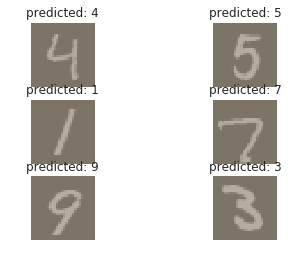

In [213]:
visualize_model(model)

In [0]:
def predict_model(model,inputs):
    model.eval()

    with torch.no_grad():

        inputs = inputs.to(device)
        outputs = model(inputs)[0]
        preds = torch.max(outputs, 1)[1].data.squeeze()
        return preds




In [0]:
data = next(iter(test_loader))

In [208]:
data.size()

torch.Size([512, 1, 28, 28])

torch.Size([3, 32, 242])
(32, 242, 3)


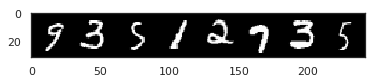

In [211]:
def 
temp0 = torchvision.utils.make_grid(data[:8,:,:,:])

temp0=temp0.numpy().transpose((1,2,0))


plt.imshow(temp0)
plt.show()